<a href="https://colab.research.google.com/github/Bharath2/cube/blob/master/flexible_link_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PyDrake Setup**

In [ ]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='15cfd96b0bdfd1b0c67597c24f91907776c02a6d', drake_version='0.27.0', drake_build='release')

!pip install recordclass

Cloning into '/opt/underactuated'...

HEAD is now at 15cfd96 and again

ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
ERROR: bokeh 2.3.1 has requirement pillow>=7.1.0, but you'll have pillow 7.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.




     |████████████████████████████████| 163kB 4.4MB/s 
  Created wheel for recordclass: filename=recordclass-0.14.3-cp37-cp37m-linux_x86_64.whl size=344681 sha256=abc63c2666df1385f66eefab4697003579b5d45a8eb09ddfd1f28ad434fb58c9
  Stored in directory: /root/.cache/pip/wheels/c2/fa/9f/abec56a7c5d6843a053f2aa53166c556be33c169438c57e483
Successfully built recordclass


###setup meshcat server

In [ ]:
server_args = ['--ngrok_http_tunnel']

from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

#**import modules**

In [ ]:
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import count


from pydrake.all import (
    DiagramBuilder, SceneGraph, Simulator, RigidTransform, 
    AddMultibodyPlantSceneGraph, Parser, RotationMatrix, PlanarSceneGraphVisualizer,
    LeafSystem, BasicVector, RevoluteSpring, AddTriad, RollPitchYaw
)

import pydrake.systems.meshcat_visualizer as meshcat_visualizer

#**URDF**

In [ ]:
!pip install xacro

In [ ]:
%%file model
<?xml version="1.0"?>

<robot xmlns:xacro="http://www.ros.org/wiki/xacro" name="RR">

  <xacro:macro name="Link" params="id damping color">
  <link name="link${id}">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="0.125" />
      <inertia ixx="0.02" ixy="0" ixz="0" iyy="0.02" iyz="0" izz="0.02" />
    </inertial>
    <visual>
      <origin xyz="0.0625 0 0" rpy="0 0 0" />
      <geometry>
        <box size="0.125 0.1 0.05"/>
      </geometry>
      <material>
        <color rgba="${color} 1" />
      </material>
    </visual>
  </link>

  <joint name="theta${id}" type="continuous">
    <parent link="link${id-1}" />
    <child link="link${id}" />
    <origin rpy="0 0 0" xyz="0.125 0 0" />
    <axis xyz="0 0 1" />
    <dynamics damping="${damping}" />
  </joint>

  </xacro:macro>

  <link name="link0">
    <visual>
      <origin xyz="0.125 0 -0.125" rpy="0 0 0" />
      <geometry>
        <cylinder length=".1" radius=".053"  />
      </geometry>
      <material>
        <color rgba="0.5 0.5 0.5 1" />
      </material>
    </visual>
  </link>

  <joint name="fixed1" type="fixed">
    <parent link="world" />
    <child link="link0" />
  </joint>

  <xacro:Link id = "1" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "2" damping = "0.1" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "3" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "4" damping = "0.1" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "5" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "6" damping = "0.1" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "7" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "8" damping = "0.1" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "9" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "10" damping = "0.1" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "11" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "12" damping = "0.1" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "13" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "14" damping = "0.1" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "15" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "16" damping = "0.1" color = "0.9 0.3 0.2"/>

  <transmission type="SimpleTransmission" name="j1">
    <actuator name="torque1" />
    <joint name="theta1" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

</robot>

Overwriting model


In [ ]:
!xacro model -o model.urdf

No module named 'rosgraph'



#Flexible Env class based on pydrake simulator

* joint damping coeff: 1 N.m.s

* joint stiffness: 5 N/m

In [ ]:
def angle_normalize(x):
    return (((x+np.pi) % (2*np.pi)) - np.pi)/np.pi

class FlexibleEnv():

  def __init__(self):
    self.Setup()
    self.reset()

  def Setup(self, visualize = False):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
    parse_ins = Parser(plant).AddModelFromFile('./model.urdf')
    #Add Revolute spring
    for i in range(2,17):
      plant.AddForceElement(RevoluteSpring(plant.GetJointByName(f"theta{i}", parse_ins), 0, 5))
    plant.Finalize()
    self.plant = plant

    # Setup visualization
    self.visualizer = None
    if visualize:
      self.visualizer = meshcat_visualizer.ConnectMeshcatVisualizer(
                builder, 
                scene_graph = scene_graph, 
                zmq_url = zmq_url, 
                delete_prefix_on_load=True)
      #set planar view instead of 3d view
      self.visualizer.set_planar_viewpoint(camera_position=[0, 0, 1], 
                                  xmin=-3, xmax=1, ymin=-2, ymax=2)
    
    self.diagram = builder.Build()


  def reset(self, init_state = None):
    #reset time and simulator
    self.time = 0
    self.context = self.diagram.CreateDefaultContext()
    self.plant_context = self.plant.GetMyMutableContextFromRoot(self.context)
    self.simulator = Simulator(self.diagram, self.context)
    #set initial state
    self.set_state(init_state)
    return self.get_state
  
  def set_state(self, init_state = None):
    if not init_state:
      init_state = np.random.uniform(-1,1,4)
      init_state = init_state * [np.pi, 1, np.pi/6, 0.1]
    init_state = [init_state[0]] + [init_state[1]/8]*15 + [init_state[2]] + [init_state[3]/8]*15
    self.plant_context.SetContinuousState(init_state)

  @property
  def get_state(self):
    #get current state from plant
    state = self.plant.get_state_output_port().Eval(self.plant_context)
    state[0] = angle_normalize(state[0])
    return state


  def step(self, u, dt = 0.05):
    #Set joint torque with input
    self.plant.get_actuation_input_port().FixValue(self.plant_context, u)
    #Advance to next step
    self.simulator.AdvanceTo(self.time + dt)
    self.time += dt
    #return current state
    return self.get_state
  
  
  def start_recording(self, init_state = None):
    self.Setup(True)
    self.reset(init_state)
    self.visualizer.load()
    self.visualizer.start_recording()
  
  def stop_recording(self):
    self.visualizer.stop_recording()
    self.visualizer.publish_recording()

  def render(self, model, init_state = None):
    self.start_recording(init_state)
    
    for i in range(200):
      u = model(self.get_state)
      self.step(u)
    
    self.stop_recording()


##**Test Env**

In [ ]:
angle_normalize(np.pi-0.01)

0.9968169011381621

In [ ]:
env = FlexibleEnv()

In [ ]:
env.reset([-np.pi/4,0,0,0])

array([-0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

In [ ]:
env.get_state

array([-0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

In [ ]:
# env.start_recording()

#env.step(joint_torques, duration)
env.step([-3], 0.02) 
# env.step([1],6)
# env.step([-1],3)

# env.stop_recording()

array([-2.56512050e-01,  2.51122439e-02, -4.45656934e-04, -1.10559639e-03,
       -8.31882918e-04, -6.09901982e-04, -4.47064930e-04, -3.28046766e-04,
       -2.41190526e-04, -1.77981140e-04, -1.32221617e-04, -9.94257039e-05,
       -7.63780630e-05, -6.08180507e-05, -5.11719145e-05, -4.47975750e-05,
       -1.96490860e+00,  2.36422346e+00,  1.53277533e-02, -1.06529654e-01,
       -8.26029906e-02, -6.06198605e-02, -4.44216024e-02, -3.25841930e-02,
       -2.39482678e-02, -1.76654429e-02, -1.31184411e-02, -9.86051669e-03,
       -7.57156676e-03, -6.02642153e-03, -5.06323261e-03, -4.33055040e-03])

##Apply constant torque

In [ ]:
def model(state):
  return [1]
  
env.render(model)

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://337119e20561.ngrok.io/static/
Connected to meshcat-server.


#Import Torch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal

# if gpu is to be used
if torch.cuda.is_available():
  device = torch.device("cuda")
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
  device = torch.device("cpu")
  torch.set_default_tensor_type(torch.FloatTensor)

##Util to Plot reward


In [ ]:
from IPython import display as ipythondisplay

tic = time.time()
def plot(reward):
    global tic
    if time.time() - tic > 2:

      plt.cla()
      plt.plot(reward)
      plt.xlabel('episodes')
      plt.ylabel('rewards')

      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
      tic = time.time()

#Sparse Reward

In [ ]:
def Reward(states, goal_states, epsilon):  

  dist = (states[:,0] - goal_states[:,0])**2
  dist += (states[:,5] - goal_states[:,5])**2
  dist = (dist)**(0.5)

  #reward is 0 if dist < epsilon, -1 if dist > epsilon
  rewards = -(dist > epsilon).float()

  return rewards.unsqueeze(1)

###Memory for [HindSight Experience Replay](https://arxiv.org/pdf/1707.01495.pdf)

In [ ]:
from recordclass import recordclass

Transitions = recordclass('Transitions', ('states', 'goal_states', 'actions', 'next_states'))

class ReplayMemory():
    def __init__(self, capacity = 1000, state_dim = 32, goal_dim = 32, action_dim = 1, Her_k = 8):
      
        self.length = 0
        self.prev_length = 0
        self.capacity = capacity
        self.Her_K = Her_k

        self.states = np.zeros((capacity, state_dim))
        self.goal_states = np.zeros((capacity, Her_k, goal_dim))
        self.actions = np.zeros((capacity, action_dim))
        self.next_states = np.zeros((capacity, state_dim))

        self.temp_states = []
      
    def add_transition(self, *args):
        index = self.length % self.capacity

        self.temp_states.append(args[0])

        self.states[index] = args[0]
        self.goal_states[index][0] = args[1]
        self.actions[index] = args[2]
        self.next_states[index] = args[3]

        self.length += 1
    
    def add_goal_states(self):
        n = len(self.temp_states)
        temp_states = np.array(self.temp_states)
        self.temp_states = []
        for i in range(n):
          start = i if (n-i) > self.Her_K else n - self.Her_K

          goal_inds = np.random.randint(start,n,self.Her_K-1)

          ind = self.prev_length % self.capacity
          self.goal_states[ind][1:,:] = temp_states[goal_inds]
          self.prev_length += 1
        

    def sample(self, batch_size):

        maxind = min(self.length, self.capacity)
        inds = np.random.choice(maxind, batch_size)
        goal_inds = np.random.choice(self.Her_K, batch_size)

        batch = Transitions(self.states[inds],
                            self.goal_states[inds,goal_inds],
                            self.actions[inds],
                            self.next_states[inds]
                            )
        
        for i in range(4):
          batch[i] = torch.tensor(batch[i], dtype=torch.float)

        return batch
        
    def __len__(self):
      return min(self.length, self.capacity)

#**Q-value Network**

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_dim = 32, goal_dim = 32, action_dim = 1):
        super(DQN, self).__init__()
        self.l11 = nn.Linear(state_dim, 64)
        self.l11.weight.data.uniform_(-0.05,0.05)
        self.l11.bias.data.fill_(0.01)

        self.l12 = nn.Linear(goal_dim, 64)
        self.l12.weight.data.uniform_(-0.05,0.05)
        self.l12.bias.data.fill_(0.01)

        self.l13 = nn.Linear(action_dim, 16)
        self.l13.weight.data.uniform_(-0.05,0.05)
        self.l13.bias.data.fill_(0.01)

        self.l2 = nn.Linear(144, 256)

        self.l3 = nn.Linear(256, 1)
        self.l3.weight.data.uniform_(-0.003,0.003)
        self.l3.bias.data.fill_(0.001)

    def forward(self, states, goal_states, actions):
        states = torch.tanh(self.l11(states))
        goal_states = torch.tanh(self.l12(goal_states))
        actions = torch.tanh(self.l13(actions))
        x = torch.cat((states, goal_states, actions),1)
        x = torch.relu(self.l2(x))
        x = self.l3(x)
        return x


#**Double DQN critic** 

In [ ]:
class Critic(nn.Module):
  def __init__(self):
    super(Critic, self).__init__()
    self.q1 = DQN()
    self.q2 = DQN()
  
  def predict(self, states, goal_states, actions):
    q1 = self.q1(states, goal_states, actions)
    q2 = self.q2(states, goal_states, actions)
    return q1, q2
  
  def forward(self, states, goal_states, actions):
    q1, q2 = self.predict(states, goal_states, actions)
    return torch.min(q1, q2)
  
  def Cal_loss(self, expected_critic_values, batch):
    q1, q2 = self.predict(batch.states, batch.goal_states, batch.actions)
    loss1 = F.smooth_l1_loss(expected_critic_values, q1)
    loss2 = F.smooth_l1_loss(expected_critic_values, q2)
    return loss1 + loss2

#**Policy network**

In [ ]:
class Policy(nn.Module):

    def __init__(self, state_dim = 32, goal_dim = 32, action_dim = 1, action_limit = 4):
        super(Policy, self).__init__()

        self.act_lim = action_limit

        self.l11 = nn.Linear(state_dim, 64)
        self.l11.weight.data.uniform_(-0.05,0.05)
        self.l11.bias.data.fill_(0.01)

        self.l12 = nn.Linear(goal_dim, 64)
        self.l12.weight.data.uniform_(-0.05,0.05)
        self.l12.bias.data.fill_(0.01)

        self.l2 = nn.Linear(128, 256)

        self.mean_layer = nn.Linear(256, action_dim)
        self.mean_layer.weight.data.uniform_(-0.01,0.01)
        self.mean_layer.bias.data.fill_(0.01)

        self.log_std = nn.Linear(256, action_dim)
        self.log_std.weight.data.uniform_(-0.005,0.005)
        self.log_std.bias.data.fill_(0.005)

    def forward(self, states, goal_states, training = True):
        states = torch.tanh(self.l11(states))
        goal_states = torch.tanh(self.l12(goal_states))

        x = torch.cat((states, goal_states), 1)
        x = torch.relu(self.l2(x))

        mean = self.mean_layer(x)
        std = torch.exp(self.log_std(x).clamp(-20, 2))

        if not training:
          sample = mean
        else:
          sample = mean + std * torch.randn(mean.size())

        action = torch.tanh(sample)

        log_probs = Normal(mean, std).log_prob(sample) - torch.log(1 - action**2 + 1e-8)

        return self.act_lim * action, std, log_probs

    def choose_action(self, state, goal_state, training = True, verb = 0):
        state = torch.tensor(state, dtype = torch.float).unsqueeze(0)
        goal_state = torch.tensor(goal_state, dtype = torch.float).unsqueeze(0)

        action, std, _  = self.forward(state, goal_state, training)
        action, std = action.item(), std.item()
        if verb: print(action, std)
        
        return [round(action, 5)]
        

##Traininig utils

In [ ]:
def Optimize(model, optimizer, loss):
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1) 
        # param.grad.data[torch.isnan(param.grad.data)] = 0
    optimizer.step()

In [ ]:
def soft_update(target, source, tau):
	for a, b in zip(target.parameters(), source.parameters()):
		a.data.copy_(a.data * (1.0 - tau) + b.data * tau)

#**Initialize**

In [ ]:
gamma = 0.99
epsilon = 0.075

actor = Policy().to(device)
target_actor = Policy().to(device)

critic = Critic().to(device)
target_critic = Critic().to(device)

target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

memory = ReplayMemory(300000)

actor_optimizer = optim.Adam(actor.parameters(),1e-3)
critic_optimizer = optim.Adam(critic.parameters(),1e-3)


reward_list = []
avg_rewards = [-300]

#**Single training step**

In [ ]:
def train_step():
    if len(memory) < 2000: return

    batch = memory.sample(64)

  #---------------------critic training----------------------------------
    next_actions, std, log_probs = actor(batch.next_states, batch.goal_states)
    next_critic_values = target_critic(batch.next_states, batch.goal_states, next_actions).detach()

    expected_critic_values = Reward(batch.states, batch.goal_states, epsilon) + gamma * (next_critic_values - 0.1*log_probs)
    expected_critic_values = expected_critic_values.clamp(-150, 150)

    critic_loss = critic.Cal_loss(expected_critic_values.detach(), batch)

    Optimize(critic, critic_optimizer, critic_loss)
  #---------------------------------------------------------------------


  #-----------------Freeze critic parameters-----------------------------
    for param in critic.parameters():
        param.requires_grad = False
  #------------------------------------------------------------------------


  #---------------------actor training----------------------------------
    actions, std, log_probs = actor(batch.states, batch.goal_states)
    critic_value = critic(batch.states, batch.goal_states, actions)
    actor_loss = torch.mean(-critic_value + 0.1*log_probs)

    Optimize(actor, actor_optimizer, actor_loss)
  #-----------------------------------------------------------------------


  #--------------------UnFreeze critic parameters-----------------------------
    for param in critic.parameters():
        param.requires_grad = True
  #-------------------------------------------------------------------------


  #----------------soft update targets--------------------------------------
    soft_update(target_actor, actor, 0.005)
    soft_update(target_critic, critic, 0.005)
  #-------------------------------------------------------------------------

#**Training**

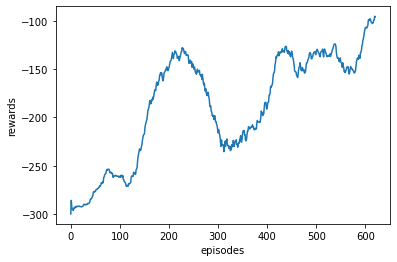

100%|██████████| 10/10 [00:41<00:00,  4.19s/it]


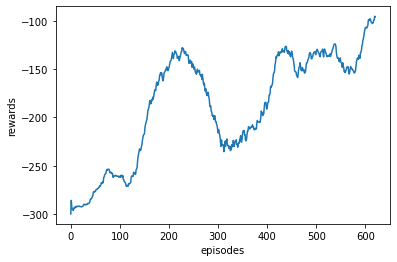

In [ ]:
env = FlexibleEnv()

for i_episode in tqdm(range(10)):

  state = env.reset()
  total_reward = 0
  goal_state = [np.random.uniform(-1,1)]+ [0]*31

  print(state, goal_state)

  for steps in range(500):

    action = actor.choose_action(state, goal_state)
    next_state = env.step(action)
    memory.add_transition(state, goal_state, action[0], next_state)

    dist = (state[0] - goal_state[0])**2
    dist += (state[5] - goal_state[5])**2
    dist = (dist)**(0.5)
    dist = -int(dist>epsilon)
    total_reward += dist

    state = next_state
  
  memory.add_goal_states()
  for _ in range(300):   
    train_step()

  # epsilon *= 0.998
  reward_list.append(total_reward)
  avg_rewards.append(np.mean(reward_list[-40:])) 

  plot(avg_rewards)

#Test Learned Policy

In [ ]:
def Go_to(goal = np.pi/2, init_state = None, verb = 0):

  goal_state = [goal/np.pi]+[0]*31

  policy = lambda state: target_actor.choose_action(state, goal_state, False, verb)

  #Simulate with learned policy
  env = FlexibleEnv()

  # print(env.get_state)
  env.start_recording(init_state)

  prev_theta = 0
    
  for i in range(500):
      state = env.get_state
      theta = state[1]
      # print((theta - prev_theta)*20)
      prev_theta = theta
      u = policy(state)
      dist = ((state[1] - goal_state[0])**2 )**(0.5)
      # print(state, dist, '\n')
      env.step(u)
    
  env.stop_recording()


  #Add target angle Marker in visualiser
  R = RollPitchYaw([np.pi/4, 0, goal])
  T = RigidTransform(R, [0.125,0,0]).GetAsMatrix4()
  AddTriad(env.visualizer.vis, name='target', prefix='', length=1, radius=0.01, opacity=0.8)
  env.visualizer.vis['']['target'].set_transform(T)

In [ ]:
Go_to(0, [5*np.pi/6,0,0,0], 0)

# env.get_state

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://337119e20561.ngrok.io/static/
Connected to meshcat-server.


In [ ]:
batch = memory.sample(400*300)

In [ ]:
data = batch.states

In [ ]:
data = data - data.mean(axis=0) # Center data points
print("Centered Matrix: ", data)


Centered Matrix:  tensor([[-0.5824,  0.0636,  0.0578,  ...,  0.0801,  0.0937,  0.0721],
        [-0.4916,  0.1676, -0.0837,  ..., -0.1356, -0.1532, -0.1051],
        [ 0.6792,  0.0346, -0.0454,  ..., -0.0225, -0.0881, -0.0812],
        ...,
        [-0.7557,  0.0348, -0.0385,  ...,  0.0260,  0.0124, -0.0083],
        [ 0.0586,  0.0724, -0.0268,  ..., -0.1215, -0.1546, -0.1000],
        [-0.3276,  0.0654, -0.0556,  ..., -0.3198, -0.3416, -0.2301]])


In [ ]:
cov = np.cov(data.T) / data.shape[0] # Get covariance matrix
print("Covariance matrix: ", cov)

Covariance matrix:  [[ 2.85207102e-06  9.48905766e-09  2.57949934e-10 ... -2.63074931e-09
  -1.50582870e-09 -1.10891963e-09]
 [ 9.48905766e-09  1.17200458e-07  4.10700124e-08 ... -1.19071693e-09
  -3.82264570e-09 -3.44724868e-09]
 [ 2.57949934e-10  4.10700124e-08  6.63481819e-08 ...  2.79452004e-09
   1.62068801e-10 -1.52028348e-09]
 ...
 [-2.63074931e-09 -1.19071693e-09  2.79452004e-09 ...  6.91936453e-07
   6.63209973e-07  3.89129965e-07]
 [-1.50582870e-09 -3.82264570e-09  1.62068801e-10 ...  6.63209973e-07
   7.90732373e-07  5.24493767e-07]
 [-1.10891963e-09 -3.44724868e-09 -1.52028348e-09 ...  3.89129965e-07
   5.24493767e-07  3.76441889e-07]]


In [ ]:
v, w = np.linalg.eig(cov)

In [ ]:
idx = v.argsort()[::-1] # Sort descending and get sorted indices
v = v[idx] # Use indices on eigv vector
w = w[:,idx] # 

print("Eigenvalue vektoru: ", v)
print("Eigenvektorler: ", w)


Eigenvalue vektoru:  [1.26796396e-04 2.07345803e-05 8.52210175e-06 4.43729325e-06
 2.95286423e-06 2.84773342e-06 1.79741168e-06 1.35001399e-06
 8.59487226e-07 3.80349328e-07 2.56869338e-07 1.42614104e-07
 6.90605960e-08 5.80523286e-08 3.43887552e-08 1.81976665e-08
 1.05837236e-08 4.50806150e-09 3.00396146e-09 7.30088717e-10
 3.97541287e-10 1.36295231e-10 4.40257767e-11 2.63500309e-11
 1.37653292e-11 2.99349784e-12 1.67710046e-12 3.73236640e-13
 1.44628533e-13 1.49802077e-14 2.34493821e-15 1.68915426e-16]
Eigenvektorler:  [[ 2.92445862e-04  1.09714855e-02 -1.26174255e-04 ...  4.56219374e-07
   1.76850084e-07 -3.74384701e-08]
 [-6.46329185e-03  5.40336058e-02  1.49422605e-02 ... -8.93140598e-04
  -1.20045124e-03 -4.63186523e-04]
 [ 9.86784882e-03  5.66125794e-03  4.40408070e-02 ...  1.48714141e-02
   2.45184758e-03  2.25825750e-03]
 ...
 [ 1.16991006e-03 -4.03458641e-03 -1.12184286e-02 ... -7.67786904e-03
   5.63392067e-03  3.37599191e-04]
 [ 9.25443687e-04 -3.72044207e-03 -1.49367111e-0

In [ ]:
np.where(w[:, :5] < 5e-2, 0, w[:, :5])

array([[0.        , 0.        , 0.        , 0.        , 0.12923595],
       [0.        , 0.05403361, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.

In [ ]:
data = data - data.mean(axis=0) # Center data points
print("Centered Matrix: ", data)


Centered Matrix:  tensor([[-0.5824,  0.0636,  0.0578,  ...,  0.0801,  0.0937,  0.0721],
        [-0.4916,  0.1676, -0.0837,  ..., -0.1356, -0.1532, -0.1051],
        [ 0.6792,  0.0346, -0.0454,  ..., -0.0225, -0.0881, -0.0812],
        ...,
        [-0.7557,  0.0348, -0.0385,  ...,  0.0260,  0.0124, -0.0083],
        [ 0.0586,  0.0724, -0.0268,  ..., -0.1215, -0.1546, -0.1000],
        [-0.3276,  0.0654, -0.0556,  ..., -0.3198, -0.3416, -0.2301]])


In [ ]:
rf crf

SyntaxError: ignored